In [1]:
%cd /content
!git clone https://github.com/souvik0306/Grounded-Segment-Anything

/content
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1240, done.
remote: Counting objects: 100% (355/355), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 1240 (delta 285), reused 278 (delta 278), pack-reused 885
Receiving objects: 100% (1240/1240), 120.42 MiB | 7.41 MiB/s, done.
Resolving deltas: 100% (530/530), done.


In [2]:
import os

folder_path = 'Grounded-Segment-Anything'
init_file_path = os.path.join(folder_path, '__init__.py')

# Create the __init__.py file
with open(init_file_path, 'w') as f:
    pass

In [3]:
%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 29.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [4]:
import os, sys

if not os.path.exists('Extracted'):
    os.makedirs('Extracted')

if not os.path.exists('Test Folder'):
    os.makedirs('Test Folder')

if not os.path.exists('Final Result'):
    os.makedirs('Final Result')

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [7]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [8]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2024-03-04 06:22:32--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.38, 13.35.7.82, 13.35.7.50, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   144MB/s    in 17s     

2024-03-04 06:22:50 (142 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [9]:
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Image downloaded from url: https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTc3Nzk0MS13aWtpbWVkaWEtaW1hZ2Uta293YnN1MHYuanBn.jpg and saved to: assets/inpaint_demo3.jpg.


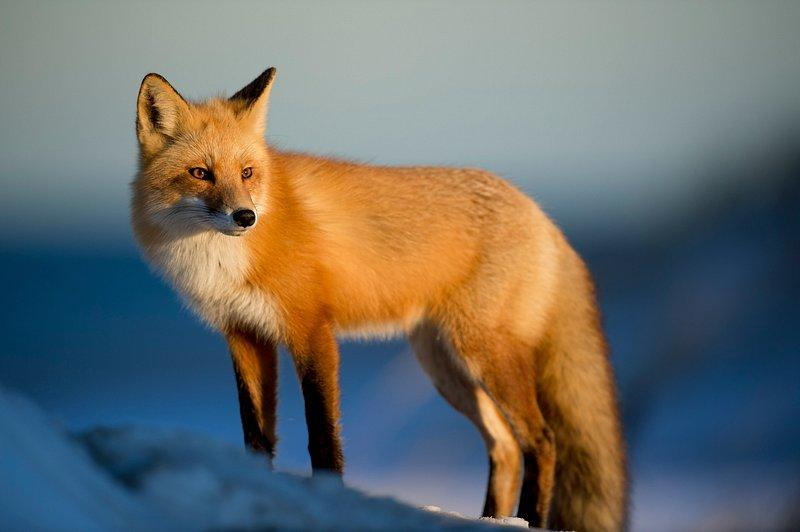

In [10]:
# Load image
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


local_image_path = "assets/inpaint_demo3.jpg"
image_url = "https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTc3Nzk0MS13aWtpbWVkaWEtaW1hZ2Uta293YnN1MHYuanBn.jpg"

download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)
Image.fromarray(image_source)

In [11]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

In [12]:
object_to_segment = "fox"

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


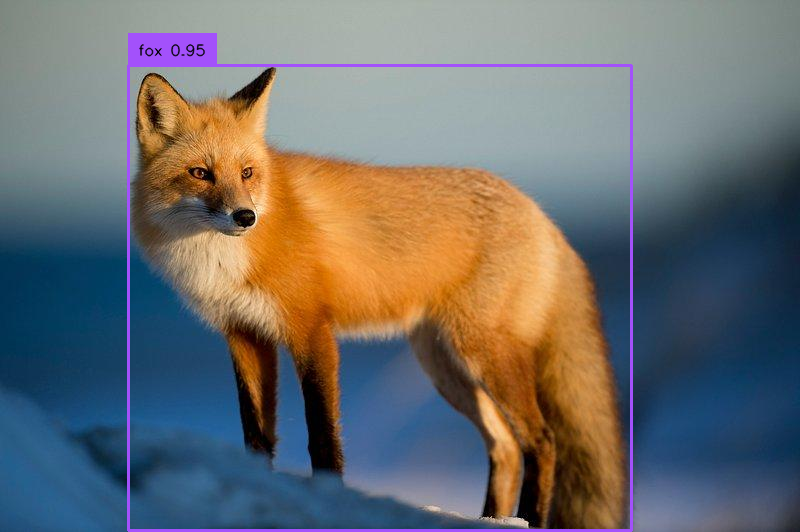

In [13]:
annotated_frame, detected_boxes = detect(image, text_prompt=object_to_segment, model=groundingdino_model)
Image.fromarray(annotated_frame)

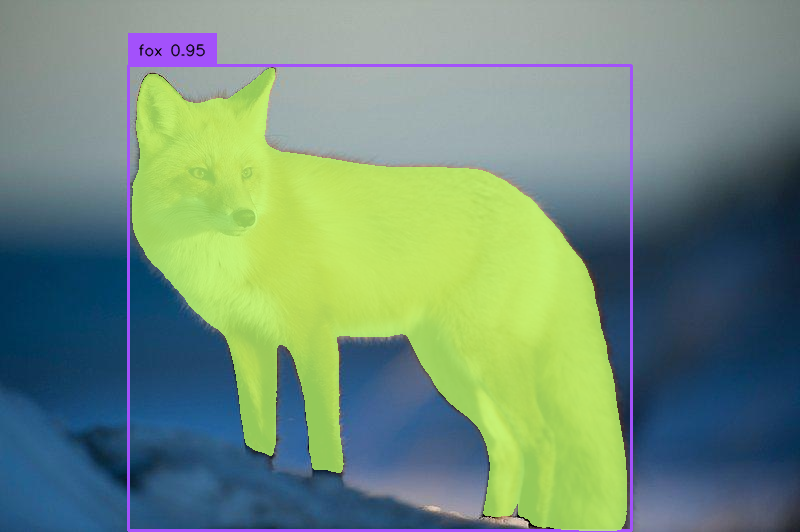

In [14]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()

def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

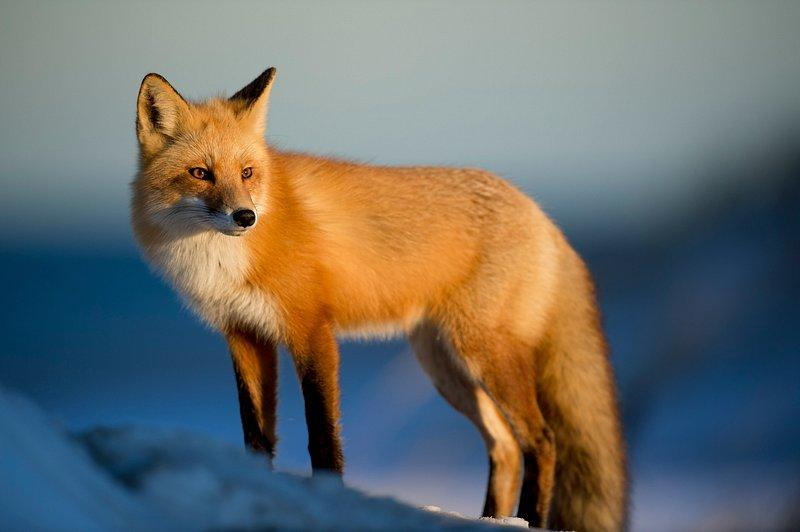

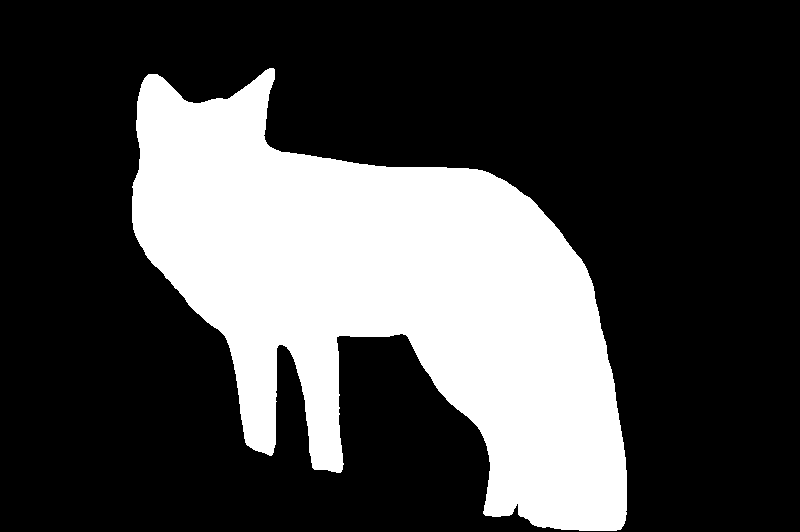

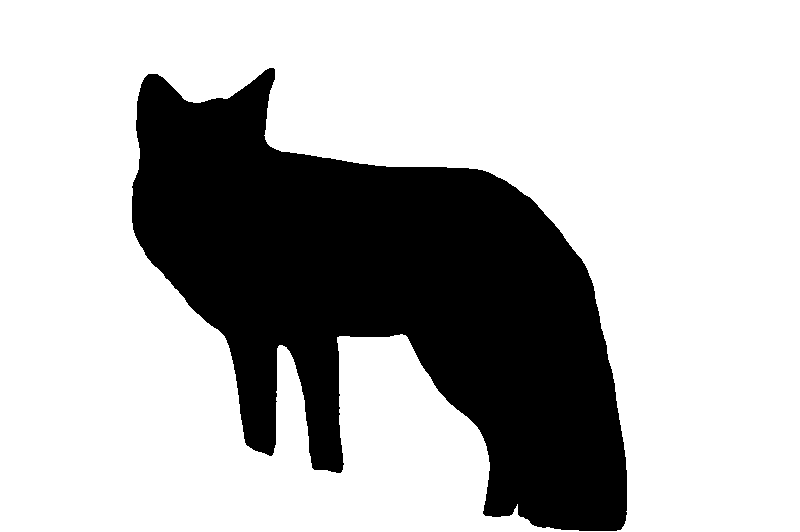

In [15]:
# create mask images
mask = segmented_frame_masks[0][0].cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image_source)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)


display(*[image_source_pil, image_mask_pil, inverted_image_mask_pil])

In [16]:
def generate_image(image, mask, prompt, negative_prompt, pipe, seed):
  # resize for inpainting
  w, h = image.size
  in_image = image.resize((512, 512))
  in_mask = mask.resize((512, 512))

  generator = torch.Generator(device).manual_seed(seed)

  result = pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
  result = result.images[0]

  return result.resize((w, h))

  0%|          | 0/50 [00:00<?, ?it/s]

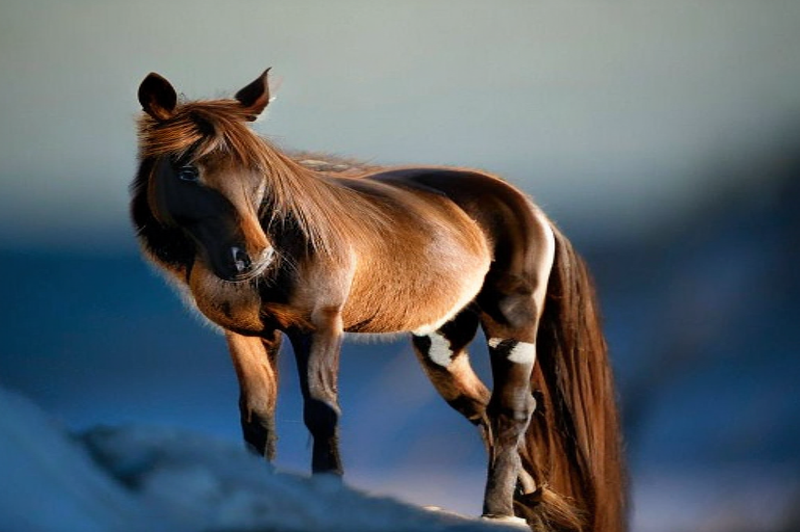

In [24]:
prompt=" a brown and black pony"
negative_prompt="low resolution, ugly"
seed = 19 # for reproducibility

generated_image = generate_image(image=image_source_pil, mask=image_mask_pil, prompt=prompt, negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
generated_image

  0%|          | 0/50 [00:00<?, ?it/s]

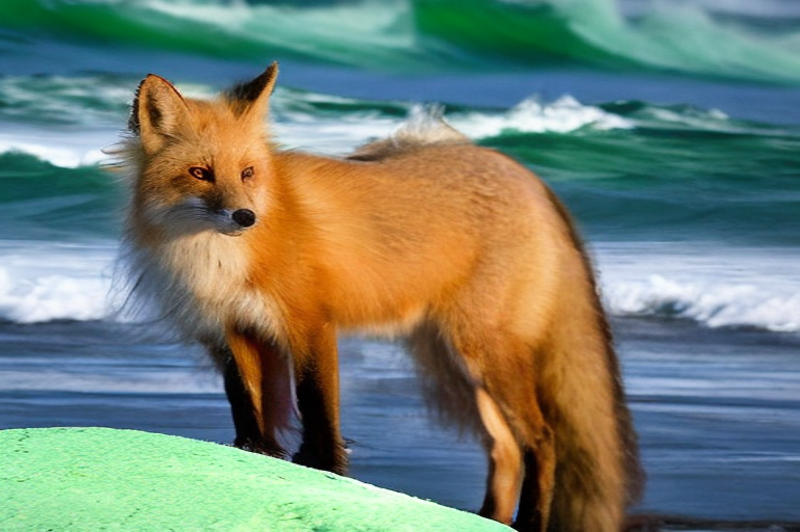

In [25]:
prompt="a green sea with high waves"
negative_prompt="people, low resolution, ugly"
seed = 41 # for reproducibility

generated_image = generate_image(image_source_pil, inverted_image_mask_pil, prompt, negative_prompt, sd_pipe, seed)
generated_image

  0%|          | 0/50 [00:00<?, ?it/s]

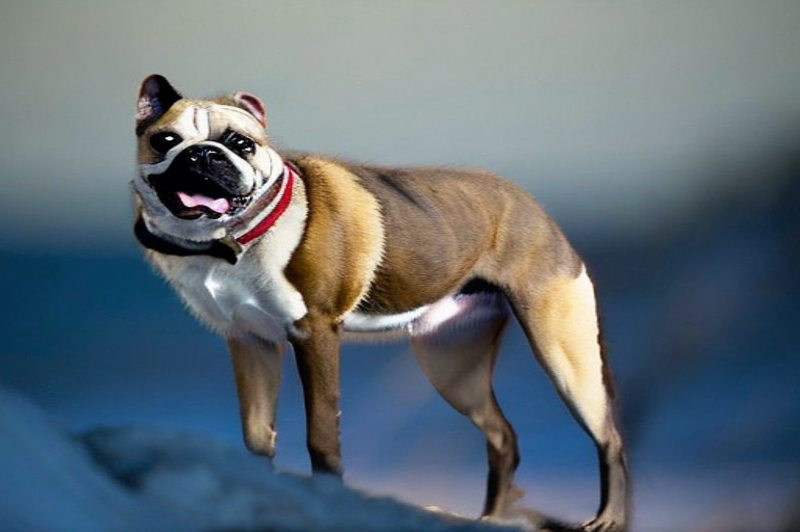

In [26]:
prompt=" a brown bulldog"
negative_prompt="low resolution, ugly"
seed = 13 # for reproducibility

generated_image = generate_image(image=image_source_pil, mask=image_mask_pil, prompt=prompt, negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
generated_image

  0%|          | 0/50 [00:00<?, ?it/s]

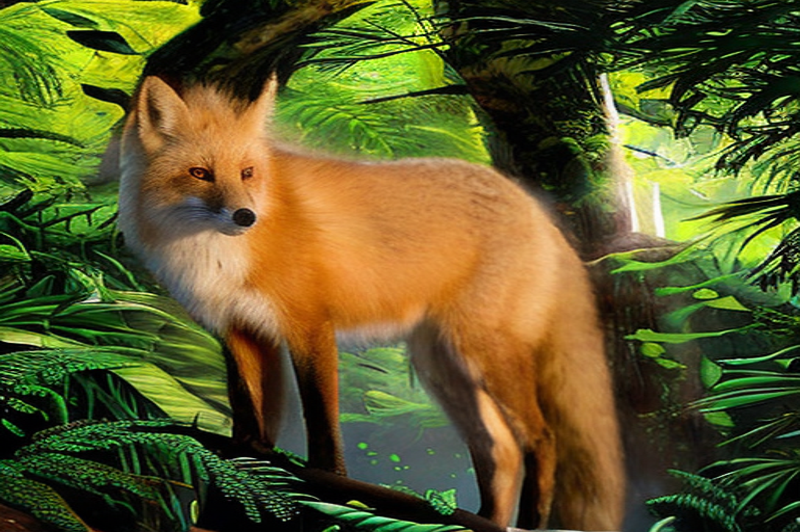

In [29]:
prompt="a mythical rainforest"
negative_prompt="people, low resolution, ugly"
seed = 29 # for reproducibility

generated_image = generate_image(image_source_pil, inverted_image_mask_pil, prompt, negative_prompt, sd_pipe, seed)
generated_image